In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Jan 11 22:07:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    13W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-12/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


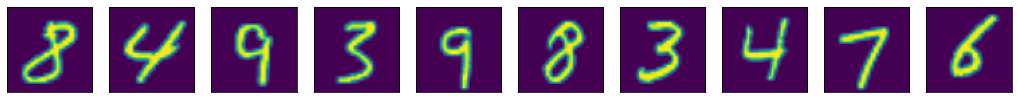

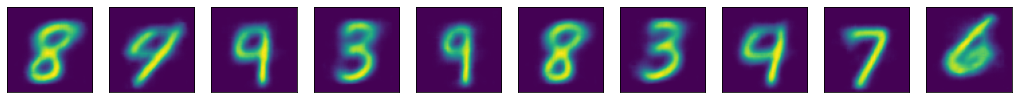

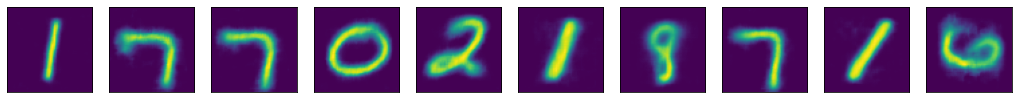

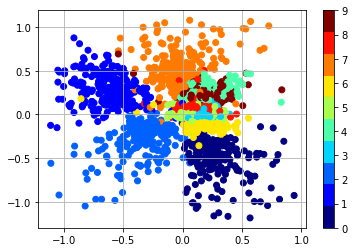

29001
lse_loss 9.458075510337949e-05
recon_loss 0.10839353501796722
29002
lse_loss 0.00021014940284658223
recon_loss 0.10203495621681213
29003
lse_loss 0.000151915563037619
recon_loss 0.13438192009925842
29004
lse_loss 7.539567013736814e-05
recon_loss 0.12499608844518661
29005
lse_loss 0.00015524293121416122
recon_loss 0.133954256772995
29006
lse_loss 0.0001627868477953598
recon_loss 0.11950188875198364
29007
lse_loss 0.0001269166386919096
recon_loss 0.10550250113010406
29008
lse_loss 0.00017390301218256354
recon_loss 0.13232406973838806
29009
lse_loss 0.00016452725685667247
recon_loss 0.14616844058036804
29010
lse_loss 0.00012299396621529013
recon_loss 0.08901947736740112
29011
lse_loss 0.00012000311107840389
recon_loss 0.11632417142391205
29012
lse_loss 0.00013218101230449975
recon_loss 0.14441826939582825
29013
lse_loss 0.00012802507262676954
recon_loss 0.11211173236370087
29014
lse_loss 0.00017294885765295476
recon_loss 0.12254743278026581
29015
lse_loss 0.0001052196603268385
recon

lse_loss 6.98711519362405e-05
recon_loss 0.12445704638957977
29129
lse_loss 0.0001239726407220587
recon_loss 0.0987713560461998
29130
lse_loss 0.0001811307156458497
recon_loss 0.12738490104675293
29131
lse_loss 0.00011444310075603426
recon_loss 0.10960705578327179
29132
lse_loss 0.000161711621331051
recon_loss 0.11642169207334518
29133
lse_loss 0.00013725645840168
recon_loss 0.09965022653341293
29134
lse_loss 0.0001518487260909751
recon_loss 0.09906219691038132
29135
lse_loss 0.00011634518159553409
recon_loss 0.09497153759002686
29136
lse_loss 0.00013367051724344492
recon_loss 0.11408759653568268
29137
lse_loss 9.479573054704815e-05
recon_loss 0.10289029777050018
29138
lse_loss 9.367083839606494e-05
recon_loss 0.11183237284421921
29139
lse_loss 0.0006531120161525905
recon_loss 0.12303577363491058
29140
lse_loss 0.0001330498926108703
recon_loss 0.1141199916601181
29141
lse_loss 0.0001232921495102346
recon_loss 0.10123687237501144
29142
lse_loss 0.0007440591580234468
recon_loss 0.1104077

lse_loss 0.00019339864957146347
recon_loss 0.10224132239818573
29251
lse_loss 0.00012376689119264483
recon_loss 0.13502207398414612
29252
lse_loss 9.656089969212189e-05
recon_loss 0.12420541048049927
29253
lse_loss 9.860998397925869e-05
recon_loss 0.1067056655883789
29254
lse_loss 0.00010280554124619812
recon_loss 0.09922953695058823
29255
lse_loss 0.00011212352546863258
recon_loss 0.11199420690536499
29256
lse_loss 0.00010552538151387125
recon_loss 0.12043178081512451
29257
lse_loss 0.00012532767141237855
recon_loss 0.09976701438426971
29258
lse_loss 0.00014987461327109486
recon_loss 0.11048328876495361
29259
lse_loss 0.0002964564482681453
recon_loss 0.11208443343639374
29260
lse_loss 0.0001248766202479601
recon_loss 0.09643131494522095
29261
lse_loss 0.00012601882917806506
recon_loss 0.1168617457151413
29262
lse_loss 9.352006600238383e-05
recon_loss 0.10689540207386017
29263
lse_loss 0.00013607944129034877
recon_loss 0.12409332394599915
29264
lse_loss 0.00014858423674013466
recon_los

lse_loss 0.00011476095824036747
recon_loss 0.11401301622390747
29376
lse_loss 0.00011026900756405666
recon_loss 0.1323765218257904
29377
lse_loss 0.0001385747455060482
recon_loss 0.14388076961040497
29378
lse_loss 0.00015785780851729214
recon_loss 0.07852628082036972
29379
lse_loss 0.0001735746773192659
recon_loss 0.10244642198085785
29380
lse_loss 0.000752332154661417
recon_loss 0.1077728271484375
29381
lse_loss 0.0007631146581843495
recon_loss 0.09028597921133041
29382
lse_loss 0.0001840004842961207
recon_loss 0.09577618539333344
29383
lse_loss 0.0001555494382046163
recon_loss 0.14284572005271912
29384
lse_loss 0.00011819770588772371
recon_loss 0.07134996354579926
29385
lse_loss 0.0001708132040221244
recon_loss 0.12366151809692383
29386
lse_loss 0.00012582872295752168
recon_loss 0.114911288022995
29387
lse_loss 0.00014213948452379555
recon_loss 0.1274959295988083
29388
lse_loss 0.0013591069728136063
recon_loss 0.11688947677612305
29389
lse_loss 0.000121714809210971
recon_loss 0.11127

29500
lse_loss 0.00013698323164135218
recon_loss 0.1205185279250145
29501
lse_loss 0.00015434945817105472
recon_loss 0.11048074811697006
29502
lse_loss 0.00014689187810290605
recon_loss 0.0847119614481926
29503
lse_loss 0.0001317585993092507
recon_loss 0.09627246856689453
29504
lse_loss 0.00012941814202349633
recon_loss 0.09667432308197021
29505
lse_loss 8.203956531360745e-05
recon_loss 0.1274871826171875
29506
lse_loss 0.0005325801321305335
recon_loss 0.09901001304388046
29507
lse_loss 9.635020251153037e-05
recon_loss 0.11920690536499023
29508
lse_loss 0.0002263409405713901
recon_loss 0.10520279407501221
29509
lse_loss 9.213974408339709e-05
recon_loss 0.10998561233282089
29510
lse_loss 0.0036580166779458523
recon_loss 0.1147848591208458
29511
lse_loss 0.00010604439012240618
recon_loss 0.14396274089813232
29512
lse_loss 0.0001176542864413932
recon_loss 0.09021499752998352
29513
lse_loss 9.73246424109675e-05
recon_loss 0.11889668554067612
29514
lse_loss 0.0001961595844477415
recon_loss 

lse_loss 0.0018030385253950953
recon_loss 0.12725815176963806
29624
lse_loss 0.00021978738368488848
recon_loss 0.09763532131910324
29625
lse_loss 0.0001318936119787395
recon_loss 0.12446775287389755
29626
lse_loss 9.514637349639088e-05
recon_loss 0.10875236988067627
29627
lse_loss 0.00010025729716289788
recon_loss 0.12363855540752411
29628
lse_loss 0.00011482290574349463
recon_loss 0.12474062293767929
29629
lse_loss 0.0001270127686439082
recon_loss 0.12495404481887817
29630
lse_loss 0.00016397408035118133
recon_loss 0.1107511818408966
29631
lse_loss 7.144513801904395e-05
recon_loss 0.09585851430892944
29632
lse_loss 9.983800555346534e-05
recon_loss 0.11666451394557953
29633
lse_loss 0.00023361836792901158
recon_loss 0.12358992546796799
29634
lse_loss 0.00013092669541947544
recon_loss 0.10300342738628387
29635
lse_loss 9.218516061082482e-05
recon_loss 0.1088702529668808
29636
lse_loss 8.456349314656109e-05
recon_loss 0.12413428723812103
29637
lse_loss 0.0005408484139479697
recon_loss 0.

lse_loss 0.00012037577835144475
recon_loss 0.08963078260421753
29750
lse_loss 0.00010317384294467047
recon_loss 0.1242532879114151
29751
lse_loss 0.00011689568782458082
recon_loss 0.1408998668193817
29752
lse_loss 0.0001138245570473373
recon_loss 0.10758017003536224
29753
lse_loss 0.0001286933256778866
recon_loss 0.13566432893276215
29754
lse_loss 8.876038191374391e-05
recon_loss 0.11295568943023682
29755
lse_loss 0.00011321311467327178
recon_loss 0.14227399230003357
29756
lse_loss 0.00013383272744249552
recon_loss 0.120388925075531
29757
lse_loss 8.222342876251787e-05
recon_loss 0.11610966920852661
29758
lse_loss 0.00020084838615730405
recon_loss 0.14589211344718933
29759
lse_loss 0.00012034748215228319
recon_loss 0.114600270986557
29760
lse_loss 0.00012658361811190844
recon_loss 0.09189297258853912
29761
lse_loss 0.00013139564543962479
recon_loss 0.12793177366256714
29762
lse_loss 5.6108350690919906e-05
recon_loss 0.08884286880493164
29763
lse_loss 9.194423182634637e-05
recon_loss 0.

29872
lse_loss 0.00012082312605343759
recon_loss 0.13451695442199707
29873
lse_loss 0.00014112229109741747
recon_loss 0.11489592492580414
29874
lse_loss 0.00012942786270286888
recon_loss 0.1176307424902916
29875
lse_loss 0.00010056437167804688
recon_loss 0.13322369754314423
29876
lse_loss 7.104719406925142e-05
recon_loss 0.13108325004577637
29877
lse_loss 0.00015863694716244936
recon_loss 0.11756914108991623
29878
lse_loss 0.000159707065904513
recon_loss 0.10192997753620148
29879
lse_loss 0.0001645371230551973
recon_loss 0.10986616462469101
29880
lse_loss 0.00017122915596701205
recon_loss 0.12343989312648773
29881
lse_loss 0.00011592416558414698
recon_loss 0.1295369267463684
29882
lse_loss 9.111271356232464e-05
recon_loss 0.12235748022794724
29883
lse_loss 0.0004745219193864614
recon_loss 0.10060139000415802
29884
lse_loss 0.00015511758101638407
recon_loss 0.1026274561882019
29885
lse_loss 0.00012699945364147425
recon_loss 0.11710280179977417
29886
lse_loss 0.00016370954108424485
recon

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        